# Qual é o melhor plano?

A atividade consiste em analisar os dados da  empresa de telecomunicações Megaline. A empresa oferece aos seus cliente planos pré-pagos, Surf e Ultimate. O departamento comercial quer saber quais dos planos dão mais receita para ajustar o orçamento de publicidade.

Será realizada uma primeira análise dos planos baseados em uma pequena seleção de clientes. Terei dados de 500 clientes da Megaline: que clientes são, de onde eles são, qual plano usam, o número de chamadas que eles fizeram e mensagens que eles enviaram em 2018. O trabalho é analisar o comportamento dos clientes e determinar quais planos pré-pagos dão mais receita. E analisar se a receita média dos usuários da área de NY-NJ é diferente dos usuários de outras regiões.

Os planos são:

Surf

    Preço mensal: $20
    500 minutos mensais, 50 mensagens de texto, e 15 GB de dados
    Depois de exceder os limites do pacote:
        1 minuto: 3 centavos
        1 mensagem de texto: 3 centavos
        1 GB de dados: $10

Ultimate

    Preço mensal: $70
    3000 minutos mensais, 1000 mensagens de texto, e 30 GB de dados
    Depois de exceder os limites do pacote:
        1 minuto: 1 centavo
        1 mensagem de texto: 1 centavo
        1 GB de dados: $7

A empresa Megaline em relação a cobrança:

- Para chamadas, cada chamada individual é arredondada para cima: mesmo se uma chamada tenha durado apenas um segundo, será contado como um minuto. 

- Para trafego de web, sessões individuais de web não são arredondadas para cima. Ao invés disso, o total do mês é arredondado para cima. Se alguém usar 1025 megabytes esse mês, eles serão cobrados por 2 gigabytes. Arredonda segundos para minutos, e megabytes para gigabytes.

Primeiramente, será feita uma primeira visualização dos dados das quatro tabelas rebecidas. Procurarei por dados aausentes e outros problemas que possam afetar os resultados da análise. Então os dados serão enriquecidos para melhorar a análise futura. 

## Inicialização

In [1]:
# Carregando todas as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import datetime as dt
from scipy.stats import ttest_ind

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## Carregar dados

Carregando os arquivos de dados em diferentes dataFrames.

In [3]:
# Carregando plans
try:
    df_plans = pd.read_csv('megaline_plans.csv')

except:
    df_plans = pd.read_csv('/datasets/megaline_plans.csv')

In [4]:
# Carregando calls
try:
    df_calls = pd.read_csv('megaline_calls.csv')

except:
    df_calls = pd.read_csv('/datasets/megaline_calls.csv')

In [5]:
# Carregando internet
try:
    df_net = pd.read_csv('megaline_internet.csv')

except:
    df_net = pd.read_csv('/datasets/megaline_internet.csv')

In [6]:
# Carregando messages
try:
    df_mess = pd.read_csv('megaline_messages.csv')

except:
    df_mess = pd.read_csv('/datasets/megaline_messages.csv')

In [7]:
# Carregando users
try:
    df_users = pd.read_csv('megaline_users.csv')

except:
    df_users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar os dados

Os dados para este projeto estão divididos em várias tabelas. Agora será feito uma exploração inicial de cada uma para obter uma compreensão inicial dos dados. Procurarei por problemas que os dados tenham, e farei as correções necessárias em cada tabela, se necessário.

## Planos

A tabela `df_plans`(dados sobre os planos):
- `plan_name`- o nome do plano de chamadas
- `usd_monthly_fee` - preço mensal em dólares dos EUA
- `minutes_included` - pacote de minutos mensal
- `messages_included` - pacote de mensagens de texto mensal
- `mb_per_month_included` - pacote de volume de dados (em megabytes)
- `usd_per_minute` - preço por minuto depois de exceder o limite do pacote (por exemplo, se o pacote inclui 100 minutos, o  primeiro minuto excedente será cobrado)
- `usd_per_message` - preço por mensagem de texto depois de exceder o limite do pacote
- `usd_per_gb` - preço por gigabyte extra de dados após exceder o limite do pacote (1 GB = 1024 megabytes)

In [8]:
#informações gerais/resumidas sobre o DataFrame dos planos
df_plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [9]:
# Imprimir uma amostra de dados para os planos
display(df_plans.head())


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


A tabela `df_plans` apresenta as informações dos dois planos da empresa. Não foi identificado nenhum problema na tabela.

## Usuários

A tabela `df_users` (dados sobre usuários):
- `user_id` - identificação do usuário
- `first_name` - nome do usuário
- `last_name` - último sobrenome do usuário
- `age` - idade do usuário (em anos)
- `reg_date` - data da inscrição (dd, mm, aa)
- `churn_date` - a data que o usuário parou de usar o serviço (se o valor for ausente, o plano estava sendo usado quando esse dado foi gerado)
- `city` - cidade de residência do usuário
- `plan` - nome do plano

In [10]:
# Imprimir as informações gerais/resumidas sobre o DataFrame dos usuários
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [11]:
# Imprimir uma amostra de dados para usuários
display(df_users.head(10)) 

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


In [12]:
# Contagem de linhas duplicadas
df_users.duplicated().sum()

0

In [13]:
# Valores unicos da coluna city
df_users['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

A tabela `df_user` apresenta de 500 usuários dos serviços da empresa. As colunas `reg_date` e `churn_date` possuem o tipo de dado incorreto, é tipo *object* mas deve ser tipo *datetime*. Não foi encontrado em `city` nenhuma duplicata implícita.

### Corrigir dados

As colunas `reg_date` e `churn_date` terão o seu tipo tranformado para *datetime*:

In [14]:
# Transformando os tipos das colunas
df_users['reg_date']= pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date']= pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

In [15]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


In [16]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


## Chamadas

A tabela `df_calls` (dados sobre as chamadas):
- `id` - identificador de chamada unívoco
- `call_date` - data da chamada
- `duration` - duração da chamada (em minutos)
- `user_id` - o identificador do usuário que faz a chamada

In [17]:
# Imprima as informações gerais/resumidas sobre o DataFrame das chamadas
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [18]:
# Imprimir uma amostra de dados para chamadas
display(df_calls.head())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [19]:
# Contagem de linhas duplicadas
df_calls.duplicated().sum()

0

In [20]:
display(df_calls['duration'].describe())

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

A tabela `df_calls` apresenta as chamadas feitas pelos 500 usuários, com a data e a duração da chamada. A coluna `call_date` possue o tipo de dado incorreto, é tipo *object* mas deve ser tipo *datetime*. Existem tempo de duração de chamadas de 0 minutos, necessitando investigação e correção. 

### Corrigir dados

A coluna `call_date` terá o seu tipo tranformado para *datetime*:

In [21]:
# Transformando os tipos das colunas
df_calls['call_date']= pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

Investigação dos valores de duração zero:

In [22]:
display(df_calls['duration'].value_counts().head())

display(df_calls['duration'].value_counts(normalize=True).head())

0.00    26834
4.02      102
8.37      102
3.91      101
4.30      100
Name: duration, dtype: int64

0.00    0.194823
4.02    0.000741
8.37    0.000741
3.91    0.000733
4.30    0.000726
Name: duration, dtype: float64

In [23]:
df_calls.query('duration == 0').head()

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0.0
25,1001_13,1001,2018-12-24,0.0
31,1001_30,1001,2018-10-17,0.0
32,1001_31,1001,2018-11-03,0.0
34,1001_35,1001,2018-12-21,0.0


Os valores com 0 minutos representam 19% dos valores da coluna. Ele podem representar chamadas perdidas. Como a chamada não teve duração então ela não foi cobrada, sendo assim, essas chamadas serão deletadas da tabela.

In [24]:
calls_orig = len(df_calls)

In [25]:
df_calls = df_calls.drop(df_calls.query('duration == 0').index)

In [26]:
display(df_calls['duration'].value_counts().head())

8.37    102
4.02    102
3.91    101
7.61    100
4.30    100
Name: duration, dtype: int64

In [27]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         110901 non-null  object        
 1   user_id    110901 non-null  int64         
 2   call_date  110901 non-null  datetime64[ns]
 3   duration   110901 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [28]:
 len(df_calls) / calls_orig

0.8051766072530584

Todos os problemas foram resolvidos, a tabela final ficou com 80% dos dados originais.

### Enriquecer dados

Seguindo a politica de cobrança da empresa, para fazer a analise, será arredondado o tempo de duração para o minuto acima.

In [29]:
df_calls['duration'] = np.ceil(df_calls['duration'])

In [30]:
df_calls.describe()

,user_id,duration
count,110901.000000,110901.000000
mean,1247.511871,8.875907
std,139.475249,5.355181
min,1000.000000,1.000000
25%,1127.000000,5.000000
50%,1247.000000,8.000000
75%,1365.000000,12.000000
max,1499.000000,38.000000


## Mensagens

A tabela `df_mess` (dados nas mensagens de texto):
- `id` - identificador unívoco de mensagem de textos
- `message_date` - data da mensagem de texto
- `user_id` - o identificador do usuário que envia a mensagem de texto

In [31]:
# Imprima as informações gerais/resumidas sobre o DataFrame das mensagens
df_mess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [32]:
# Imprima uma amostra dos dados para as mensagens
display(df_mess.head())


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [33]:
# Contagem de linhas duplicadas
df_mess.duplicated().sum()

0

A tabela `df_mess` apresenta a data e o id das mensagens enviadas pelos usuários. A coluna `message_date` possue o tipo de dado incorreto, é tipo *object* mas deve ser tipo *datetime*.

### Corrigir dados

A coluna `message_date` terá o seu tipo tranformado para *datetime*:

In [34]:
# Transformando os tipos das colunas
df_mess['message_date']= pd.to_datetime(df_mess['message_date'], format='%Y-%m-%d')

In [35]:
df_mess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Internet

A tabela `df_net` (dados sobre sessões web):
- `id` - identificador de sessão unívoco
- `user_id` - identificador do usuário
- `session_date` - data da sessão web
- `mb_used` - o volume de dados gasto durante a sessão ( em megabytes)

In [36]:
# Imprime as informações gerais/resumidas sobre o DataFrame da Internet
df_net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [37]:
# Imprime uma amostra de dados para o tráfego da Internet
display(df_net.head())

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [38]:
df_net.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [39]:
# Contagem de linhas duplicadas
df_net.duplicated().sum()

0

A tabela `df_net` apresenta a quantida de dados utilizados em uma sessão individual e a data. A coluna `session_date` possue o tipo de dado incorreto, é tipo *object* mas deve ser tipo *datetime*. Existe na coluna `mb_used`, gasto de dados igual a zero, serão investigados como foi feito na tabela `df_calls`.

### Corrigir dados

A coluna `session_date` terá o seu tipo tranformado para *datetime*:

In [40]:
# Transformando os tipos das colunas
df_net['session_date']= pd.to_datetime(df_net['session_date'], format='%Y-%m-%d')

Investigação dos valores 0 da coluna `mb_used`:

In [41]:
display(df_net['mb_used'].value_counts().head())

display(df_net['mb_used'].value_counts(normalize=True).head())

0.00      13747
435.77        8
414.46        8
423.06        7
417.46        7
Name: mb_used, dtype: int64

0.00      0.131142
435.77    0.000076
414.46    0.000076
423.06    0.000067
417.46    0.000067
Name: mb_used, dtype: float64

In [42]:
df_net.query('mb_used == 0').head()

,id,user_id,session_date,mb_used
1,1000_204,1000,2018-12-31,0.0
14,1001_26,1001,2018-09-17,0.0
16,1001_28,1001,2018-10-17,0.0
34,1001_54,1001,2018-09-02,0.0
43,1001_77,1001,2018-10-31,0.0


Os valores com 0 megas utilizados representam 13% dos valores da coluna. Provavelmente eles representam conexões que gastaram poucos dados, muito baixo para serem coletados na casa dos megabytes. Como não é possível saber pela tabela quantos dados foram utilizados nesses valores e  o valor por mês é arredondado para cima, foi decidido que essas linhas serão deletadas da tabela.

In [43]:
net_orig = len(df_net)

In [44]:
df_net = df_net.drop(df_net.query('mb_used == 0.0000').index)

In [45]:
display(df_net['mb_used'].value_counts().sort_values(ascending=False).head())

414.46    8
435.77    8
309.68    7
355.33    7
358.90    7
Name: mb_used, dtype: int64

In [46]:
df_net.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91078 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            91078 non-null  object        
 1   user_id       91078 non-null  int64         
 2   session_date  91078 non-null  datetime64[ns]
 3   mb_used       91078 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.5+ MB


In [47]:
 len(df_net) / net_orig

0.8688576198425948

Todos os problemas foram resolvidos, a tabela final ficou com 86% dos dados originais.

### Enriquecer dados

A política de cobrança para trafego de web, sessões individuais de web não são arredondadas para cima. Ao invés disso, o total do mês é arredondado para cima. Se alguém usar 1025 megabytes esse mês, eles serão cobrados por 2 gigabytes. 

Sendo assim, a coluna `mb_used` terá os valores em de megabytes transformados para gigabytes, armazenados na nova coluna `gb_used`, a antiga será apagada.

In [48]:
df_net['gb_used'] = df_net['mb_used'] / 1024

In [49]:
df_net.drop('mb_used', axis=1, inplace=True)

In [50]:
df_net.head()

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,0.087754
2,1000_379,1000,2018-12-28,0.644922
3,1000_413,1000,2018-12-26,0.264639
4,1000_442,1000,2018-12-27,0.859590
5,1001_0,1001,2018-08-24,0.278008


## Condições do plano de estudos

Revendo os planos:

Surf

    Preço mensal: $20
    500 minutos mensais, 50 mensagens de texto, e 15 GB de dados
    Depois de exceder os limites do pacote:
        1 minuto: 3 centavos
        1 mensagem de texto: 3 centavos
        1 GB de dados: $10

Ultimate

    Preço mensal: $70
    3000 minutos mensais, 1000 mensagens de texto, e 30 GB de dados
    Depois de exceder os limites do pacote:
        1 minuto: 1 centavo
        1 mensagem de texto: 1 centavo
        1 GB de dados: $7

In [51]:
# Imprime as condições do plano
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Dados agregados por usuário

Agora, agregarei os dados por usuário por mês para ter apenas um registro por usuário por período. Agregarei por usuário por mês o número de chamadas, a quantidade de minutos gastos, o número de mensagens enviadas e o volume de tráfego de internet.


In [52]:
def pivot_df(data, dt , vl, func):
    pivot = data.pivot_table(index=['user_id',data[dt].dt.month], values=vl, aggfunc= func)
    pivot = pivot.reset_index().rename(columns={dt : 'month'})
    return pivot


In [53]:
# O número de chamadas feitas por cada usuário por mês e a quantidade de minutos gastos por cada usuário por mês.
calls_month = pivot_df(df_calls, 'call_date' , 'duration', ['count','sum'])
calls_month = calls_month.reset_index(drop=True).rename(columns={ 'duration': ''})
calls_month.reset_index(drop=True,inplace=True)

calls_month

,user_id,month,count,sum
,,,,
0,1000,12,16,124.0
1,1001,8,22,182.0
2,1001,9,38,315.0
3,1001,10,47,393.0
4,1001,11,49,426.0
...,...,...,...,...
2251,1498,12,32,339.0
2252,1499,9,35,346.0
2253,1499,10,41,385.0


In [54]:
# O número de mensagens enviadas por cada usuário por mês.
mess_month = pivot_df(df_mess, 'message_date' , 'id', 'count')

mess_month

,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [55]:
# O volume de tráfego de internet usado por cada usuário por mês.
net_month_gb = pivot_df(df_net, 'session_date' , 'gb_used', 'sum')

net_month_gb['gb_used'] = np.ceil(net_month_gb['gb_used']) 

net_month_gb.head()

,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0


Agregarei os dados em um DataFrame para que um registro represente o que um usuário único consumiu em um determinado mês de chamadas, duração da chamada, mensagens e uso de dados.

In [56]:
# Junte os dados de chamadas, minutos, mensagens, internet com base em user_id e mês
calls_mess = pd.merge(calls_month, mess_month, on=['user_id', 'month'], how='outer')

calls_mess_net = pd.merge(calls_mess, net_month_gb, on=['user_id', 'month'], how='outer')


# Retirando as colunas duplicadas
calls_mess_net = calls_mess_net.drop(calls_mess_net.columns[[2,3]],axis=1)


# Renomeando as colunas
calls_mess_net.columns = ['user_id', 'month', 'calls', 'minutes', 'messages', 'gb_used']

# Imprimindo a tabela
display(calls_mess_net)

,user_id,month,calls,minutes,messages,gb_used
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,22.0,182.0,30.0,7.0
2,1001,9,38.0,315.0,44.0,14.0
3,1001,10,47.0,393.0,53.0,22.0
4,1001,11,49.0,426.0,36.0,19.0
...,...,...,...,...,...,...
2288,1407,11,NaN,NaN,1.0,1.0
2289,1482,10,NaN,NaN,2.0,NaN
2290,1094,10,NaN,NaN,NaN,2.0
2291,1108,12,NaN,NaN,NaN,1.0


In [57]:
# Adicione as informações do plano, idade e cidade
df_final = pd.merge(calls_mess_net, df_users[['user_id','age','city','plan']], on='user_id', how='left')

df_final.head()

,user_id,month,calls,minutes,messages,gb_used,age,city,plan
0,1000,12,16.0,124.0,11.0,2.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,8,22.0,182.0,30.0,7.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1001,9,38.0,315.0,44.0,14.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf
3,1001,10,47.0,393.0,53.0,22.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf
4,1001,11,49.0,426.0,36.0,19.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf


Calcularei a receita mensal para cada usuário. Consiste em:
- Subtrair o limite do pacote grátis do número total de chamadas, mensagens de texto, e dados; 
- Multiplicar o resultado pelos valores do plano; 
- Adicionar o preço mensal dependendo do plano de chamada.

In [58]:
def calc_messages(df):
    if df['plan'] == 'surf':
        if df['messages'] >50:
            resp =(df['messages'] - 50) * 0.03
            return resp
    elif df['plan'] == 'ultimate':
        if df['messages'] >1000:
            resp =(df['messages'] - 1000) * 0.01
            return resp
        

In [59]:
def calc_calls(df):
    if df['plan'] == 'surf':
        if df['minutes'] >500:
            resp =(df['minutes'] - 500) * 0.03
            return resp
    elif df['plan'] == 'ultimate':
        if df['minutes'] >3000:
            resp =(df['minutes'] - 1000) * 0.01
            return resp
        

In [60]:
def calc_gb(df):
    if df['plan'] == 'surf':
        if df['gb_used'] >15:
            resp =(df['gb_used'] - 15) * 10
            return resp
    elif df['plan'] == 'ultimate':
        if df['gb_used'] >30:
            resp =(df['gb_used'] - 30) * 7
            return resp
        

In [61]:
def calc_base(df):
    if df['plan'] == 'surf':
            return 20
    else:
            return 70
   

In [62]:
df_final['messages_cost'] = df_final.apply(calc_messages, axis=1)
df_final['calls_cost'] = df_final.apply(calc_calls, axis=1)
df_final['gb_cost'] = df_final.apply(calc_gb, axis=1)
df_final['base_cost'] = df_final.apply(calc_base, axis=1)

In [63]:
# Calcule o excedente mensal de cada usuário
df_final['surplus_cost'] = df_final[['messages_cost', 'calls_cost', 'gb_cost']].sum(axis=1)

In [64]:
# Calcule a receita mensal de cada usuário
df_final['revenue'] = df_final[['surplus_cost','base_cost']].sum(axis=1)

In [65]:
df_final.head()

,user_id,month,calls,minutes,messages,gb_used,age,city,plan,messages_cost,calls_cost,gb_cost,base_cost,surplus_cost,revenue
0,1000,12,16.0,124.0,11.0,2.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,NaN,NaN,NaN,70,0.00,70.00
1,1001,8,22.0,182.0,30.0,7.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,NaN,NaN,NaN,20,0.00,20.00
2,1001,9,38.0,315.0,44.0,14.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,NaN,NaN,NaN,20,0.00,20.00
3,1001,10,47.0,393.0,53.0,22.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,0.09,NaN,70.0,20,70.09,90.09
4,1001,11,49.0,426.0,36.0,19.0,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,NaN,NaN,40.0,20,40.00,60.00


Foi criado o dataframe `df_final` contendo as informações necessárias para calcular os dados agregados dos serviços utilizados e da receita por mês e plano.

## Estudar o comportamento do usuário

Calcularei algumas estatísticas descritivas úteis para os dados agregados e unidos, que geralmente revelam uma imagem geral capturada pelos dados. Desenharei gráficos úteis para ajudar na compreensão. Dado que a tarefa principal é comparar os planos e decidir qual é mais rentável, as estatísticas e as parcelas devem serão calculadas por plano.



In [66]:
# Funcao para criar grafico de barras
def graf_month(pivot, ylabel, title, legend):
    df_mean = pivot

    # Cria o gráfico de barras agrupadas
    fig, ax = plt.subplots(figsize=(10,6))
    df_mean.plot(kind='bar', ax=ax,grid=True)

    # Adiciona os rótulos do eixo x e legenda
    ax.set_xlabel('Mês')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title=legend)
    plt.show()

In [67]:
# Funcao para criar grafico boxplot
def box_month(pivot, xlabel,  ylabel, title):
    # Cria o boxplot
    fig, ax = plt.subplots(figsize=(10,6))
    pivot.boxplot(ax=ax)

    # Adiciona os rótulos do eixo x e legenda
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

In [68]:
# Funcao para criar grafico de densidade
def densi_graph(df , x , hu, title, xlabel):
    sns.displot(data=df, x=x, hue=hu, kind="kde");
    plt.title(title);
    plt.ylabel('Densidade')
    plt.xlabel(xlabel)
    plt.show();

### Chamadas

In [69]:
# Distribuição dos planos no dataframe
df_final['plan'].value_counts(normalize=True)

surf        0.686001
ultimate    0.313999
Name: plan, dtype: float64

Será visto o comportamento dos dois planos em relação a duração das chamadas.

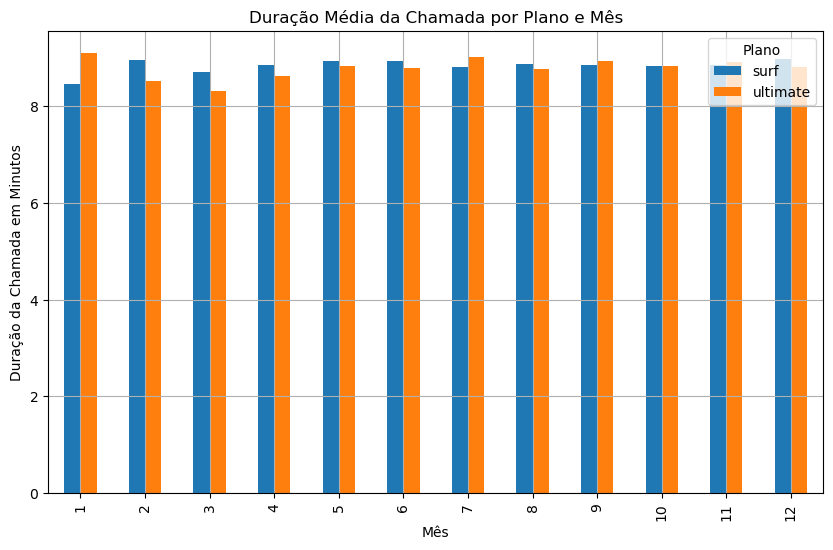

In [70]:
# Criacao de um dataframe com a duração média das ligações de cada plano para cada mês distinto.
calls_sum = df_final.pivot_table(index=['month','plan'], values='calls',aggfunc='sum')

min_sum = df_final.pivot_table(index=['month','plan'], values='minutes',aggfunc='sum')

calls_month = min_sum['minutes'] / calls_sum['calls']

calls_month = calls_month.reset_index()

# Compare a duração média das ligações de cada plano para cada mês distinto. Faça um gráfico de barras para visualizá-lo.
graf_month(calls_month.pivot_table(index='month', columns='plan', values=0, aggfunc='mean'),\
           'Duração da Chamada em Minutos', 'Duração Média da Chamada por Plano e Mês', 'Plano')


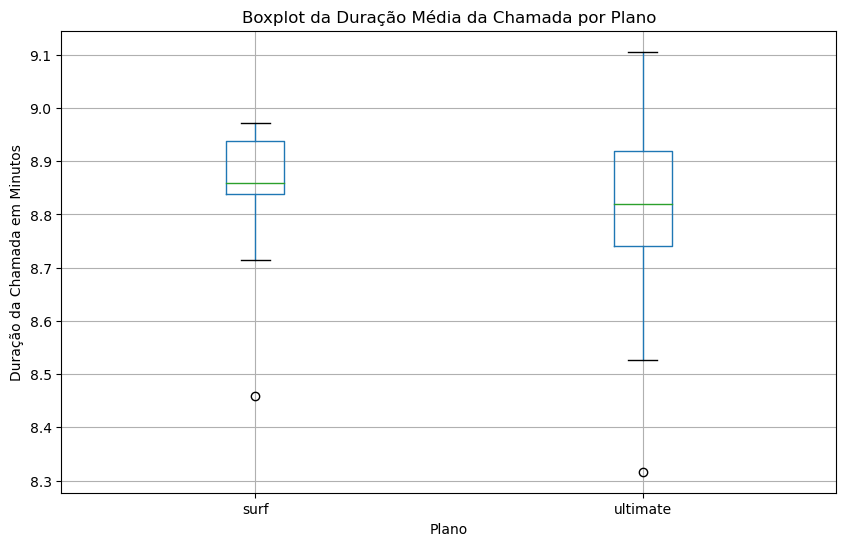

In [71]:
# Faça um diagrama de caixa para visualizar a distribuição da duração mensal das chamadas
box_month(calls_month.pivot_table(index='month', columns='plan', values=0, aggfunc='mean'),\
          'Plano', 'Duração da Chamada em Minutos', 'Boxplot da Duração Média da Chamada por Plano')

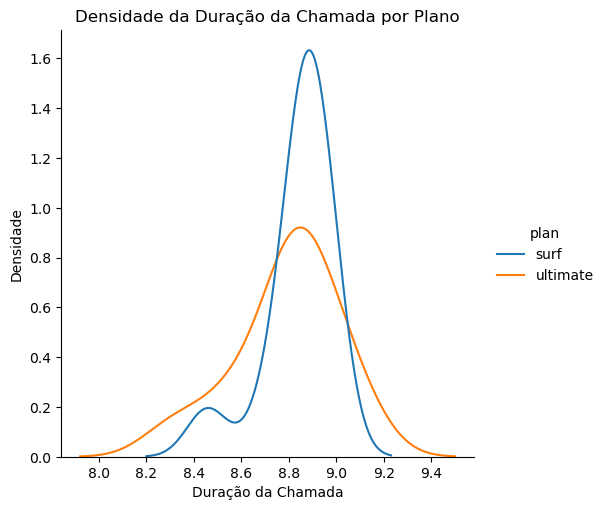

In [72]:
# Densidade da Duração da Chamada por Plano
densi_graph(calls_month , 0 , 'plan', 'Densidade da Duração da Chamada por Plano', 'Duração da Chamada')

A duração média das chamadas dos dois planos é muitos similar, não sendo identificado uma diferença de comportamento.

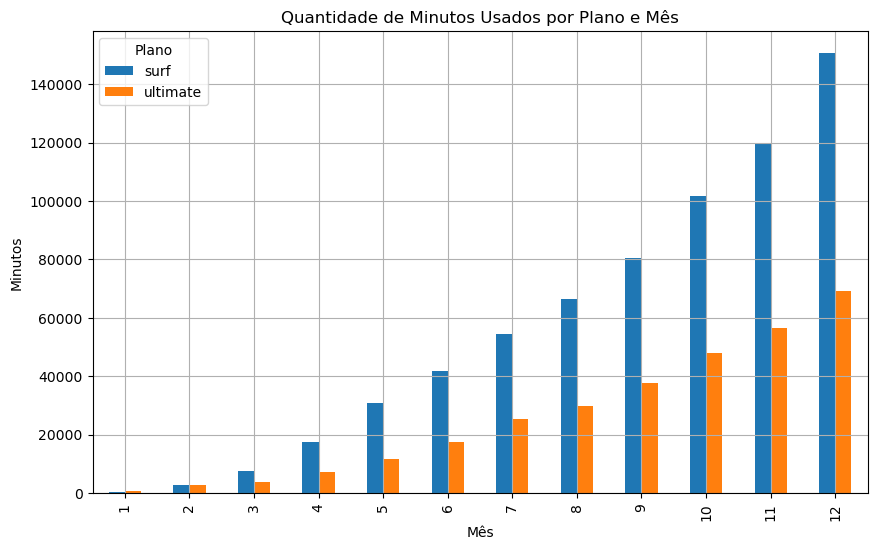

In [73]:
# Compare o número de minutos que os usuários de cada plano requerem a cada mês.
graf_month(df_final.pivot_table(index='month', columns='plan', values='minutes', aggfunc='sum'),\
           'Minutos', 'Quantidade de Minutos Usados por Plano e Mês', 'Plano')


São utilizados mais mintutos em relação aos meses. A diferença entre os planos parece proporcional a distribuição deles no dataframe. 

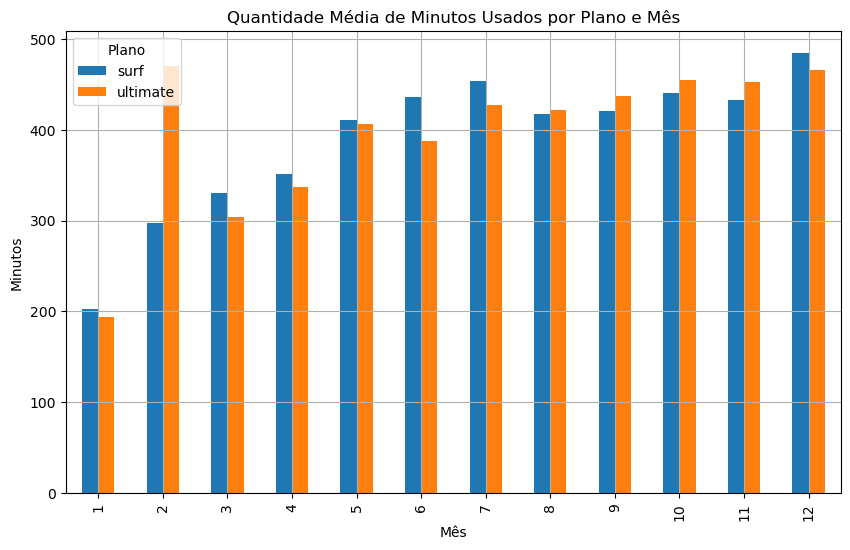

In [74]:
# Compare o número de minutos que os usuários de cada plano requerem a cada mês.
graf_month(df_final.pivot_table(index='month', columns='plan', values='minutes', aggfunc='mean'),\
           'Minutos', 'Quantidade Média de Minutos Usados por Plano e Mês', 'Plano')


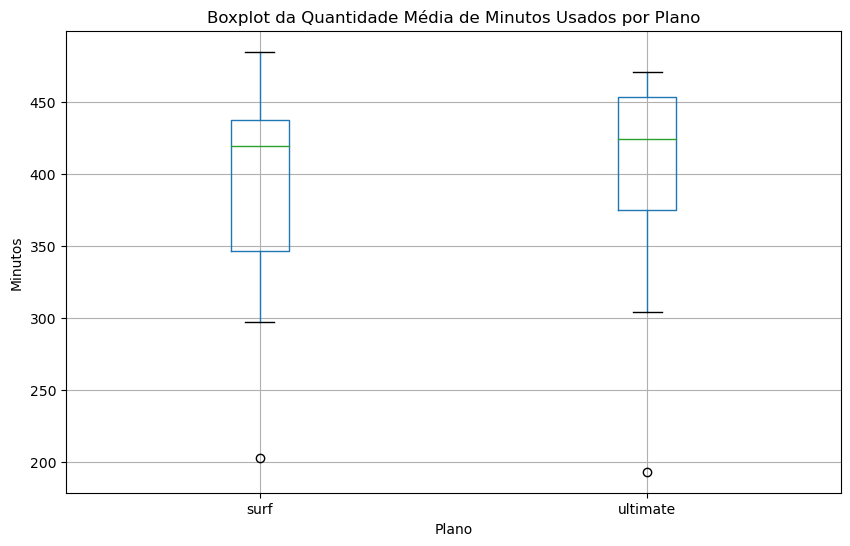

In [75]:
# Faça um diagrama de caixa para visualizar a distribuição da Quantidade Média de Minutos Usados
box_month(df_final.pivot_table(index='month', columns='plan', values='minutes', aggfunc='mean'),\
          'Plano', 'Minutos', 'Boxplot da Quantidade Média de Minutos Usados por Plano')


In [76]:
# Calcule a média e a variação da duração mensal das chamadas
display(calls_month.query('plan == "surf"')[0].describe() )
display(calls_month.query('plan == "ultimate"')[0].describe() )


count    12.000000
mean      8.843008
std       0.141354
min       8.458333
25%       8.839003
50%       8.858861
75%       8.937568
max       8.972786
Name: 0, dtype: float64

count    12.000000
mean      8.792179
std       0.216393
min       8.316629
25%       8.741655
50%       8.819987
75%       8.919654
max       9.105882
Name: 0, dtype: float64

A quantidade de média de minutos utilizados por mês possui uma mediana e média muito proxima entre os planos.

Em conclusão, não foi encontrado diferença em relação a duração da chamada e a quantidade de minutos usados entre os planos. Sendo assim, afirmo que o comportamento dos usuários em relação a chamada não é diferente entre os planos.

### Mensagens

Será visto o comportamento dos dois planos em relação a duração as mensagens.

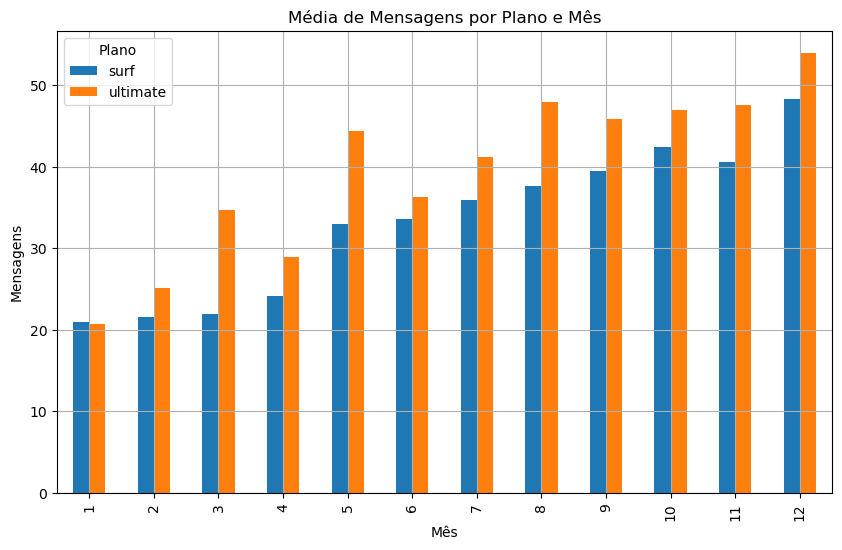

In [77]:
graf_month(df_final.pivot_table(index='month', columns='plan', values='messages', aggfunc='mean'),\
           'Mensagens', 'Média de Mensagens por Plano e Mês', 'Plano')


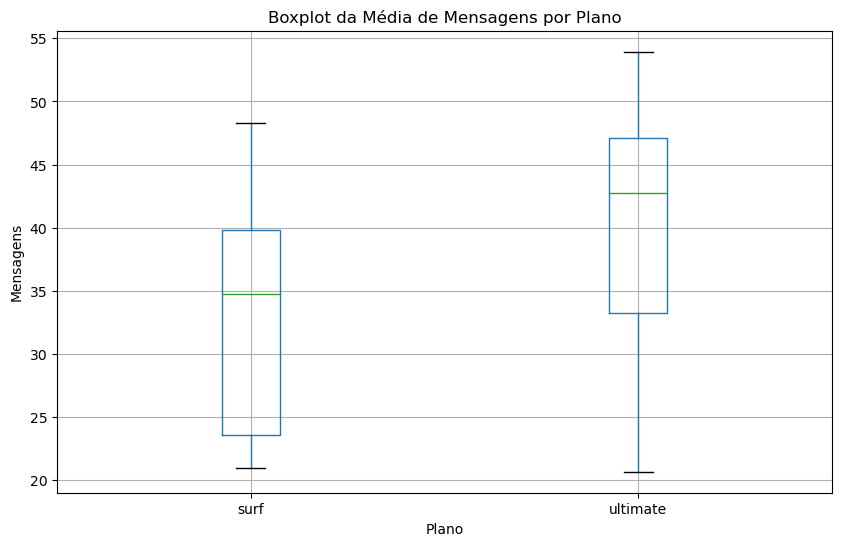

In [78]:
box_month(df_final.pivot_table(index='month', columns='plan', values='messages', aggfunc='mean'),\
          'Plano', 'Mensagens', 'Boxplot da Média de Mensagens por Plano')


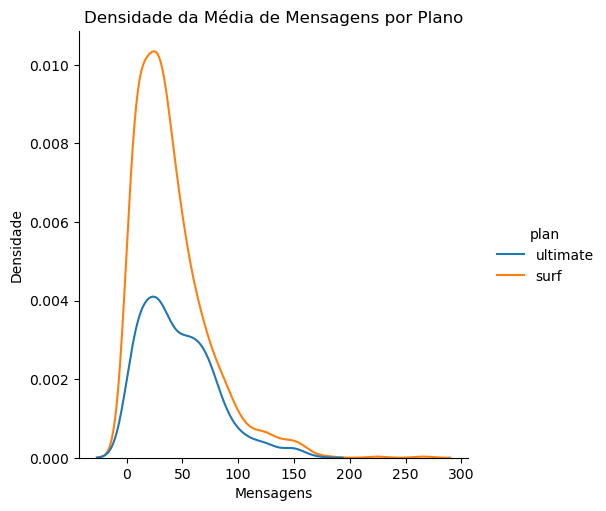

In [79]:
# Densidade da Média de Mensagens por Plano
densi_graph(df_final , 'messages' , 'plan', 'Densidade da Média de Mensagens por Plano', 'Mensagens')

In [80]:
# Calcule a média e a variação da Média de Mensagens por Plano
display(df_final.query('plan == "surf"')['messages'].describe() )
display(df_final.query('plan == "ultimate"')['messages'].describe() )


count    1222.000000
mean       40.109656
std        33.035500
min         1.000000
25%        16.000000
50%        32.000000
75%        54.000000
max       266.000000
Name: messages, dtype: float64

count    584.000000
mean      46.296233
std       32.942118
min        1.000000
25%       21.000000
50%       41.000000
75%       66.000000
max      166.000000
Name: messages, dtype: float64

Em relação a média de mensagens por mês, o consumidor do plano ultimate parece enviar em média mais mensagens por mêS.

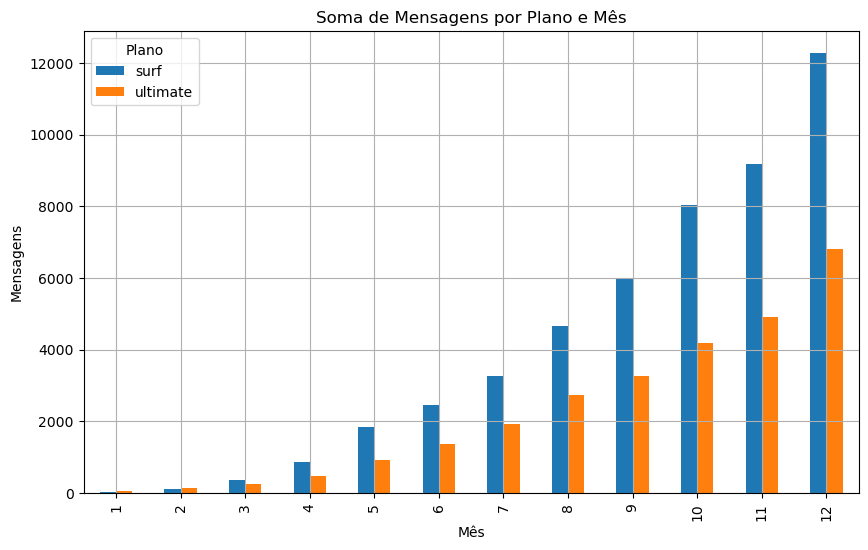

In [81]:
graf_month(df_final.pivot_table(index='month', columns='plan', values='messages', aggfunc='sum'),\
           'Mensagens', 'Soma de Mensagens por Plano e Mês', 'Plano')


São utilizados mais mensgens em relação aos meses. A diferença entre os planos parece proporcional a distribuição deles no dataframe. 

Em conclusão, parece haver uma diferença em relação a quantidade média de mensagens enviadas entre os planos quando é visto pelos boxplots, mas pelo gráfico de dispersão as duas são muito semelhantes. Sendo assim, não é possível dizer que existe diferença.

### Internet

Será visto o comportamento dos dois planos em relação a quantidade de dados utilizados.

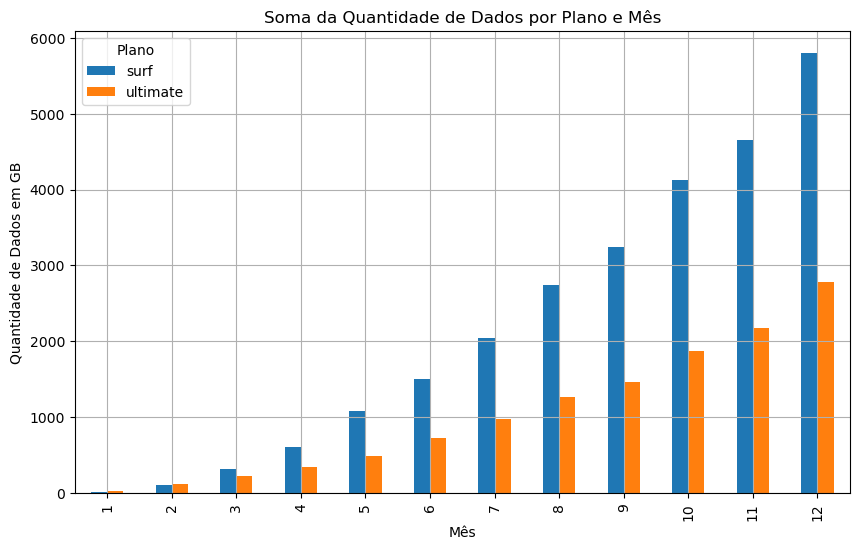

In [82]:
# Compare a quantidade de tráfego de internet consumido pelos usuários por plano
graf_month(df_final.pivot_table(index='month', columns='plan', values='gb_used', aggfunc='sum'),\
           'Quantidade de Dados em GB', 'Soma da Quantidade de Dados por Plano e Mês', 'Plano')

São utilizados mais dados em relação aos meses. A diferença entre os planos parece proporcional a distribuição deles no dataframe.

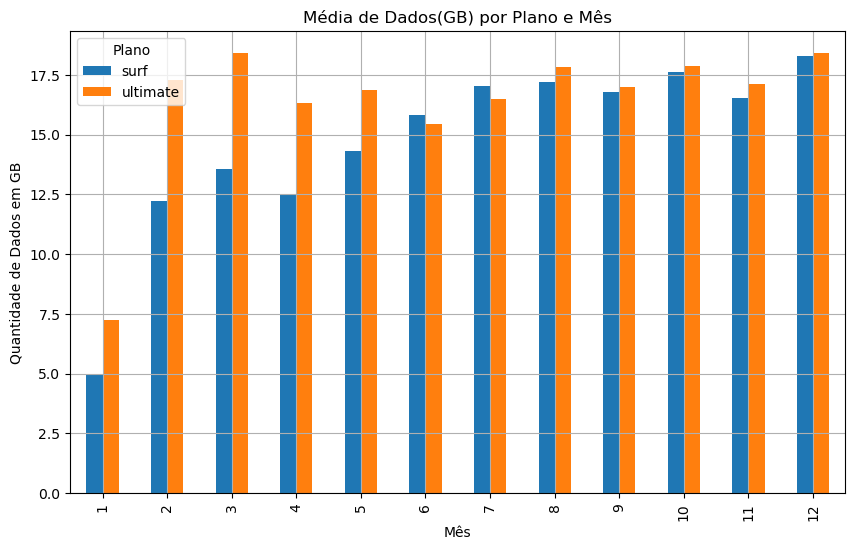

In [83]:
# Compare a quantidade média de tráfego de internet consumido pelos usuários por plano
graf_month(df_final.pivot_table(index='month', columns='plan', values='gb_used', aggfunc='mean'),\
           'Quantidade de Dados em GB', 'Média de Dados(GB) por Plano e Mês', 'Plano')


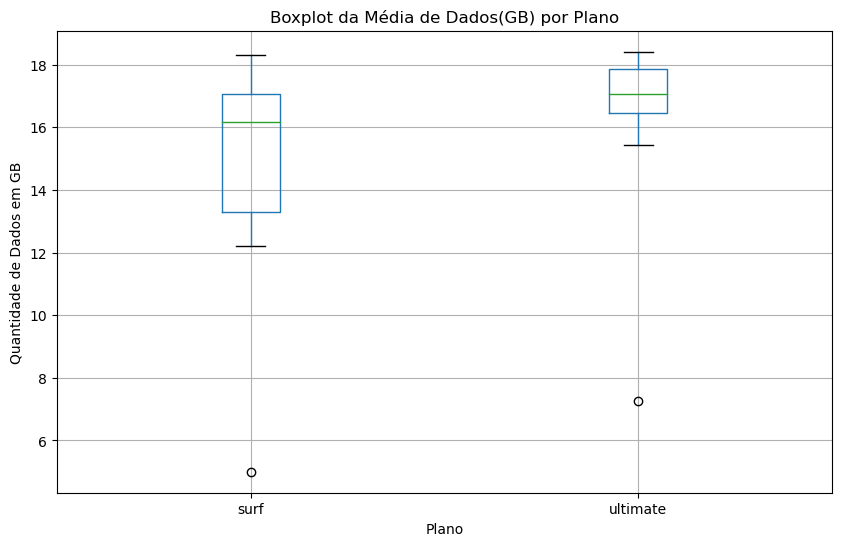

In [84]:
box_month(df_final.pivot_table(index='month', columns='plan', values='gb_used', aggfunc='mean'),\
          'Plano', 'Quantidade de Dados em GB', 'Boxplot da Média de Dados(GB) por Plano')

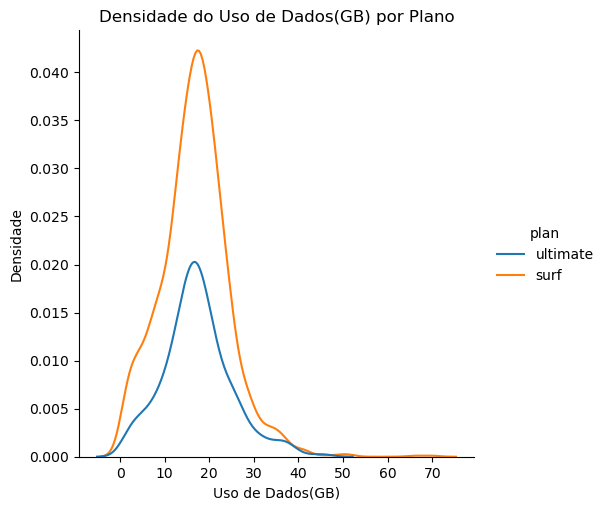

In [85]:
# Densidade do Uso de Dados(GB) por Plano
densi_graph(df_final , 'gb_used' , 'plan', 'Densidade do Uso de Dados(GB) por Plano', 'Uso de Dados(GB)')

Em coclusão, não parece haver uma diferença em relação ao uso dos dados. Na quantidade média de dados por plano, ultimate possui uma mediana maior mas as distribuições estão muitos proximas para que seja determinado uma diferença real. 

## Receita

Será visto o comportamento dos dois planos em relação a duração  receita.

In [86]:
df_final['plan'].value_counts(normalize=True)

surf        0.686001
ultimate    0.313999
Name: plan, dtype: float64

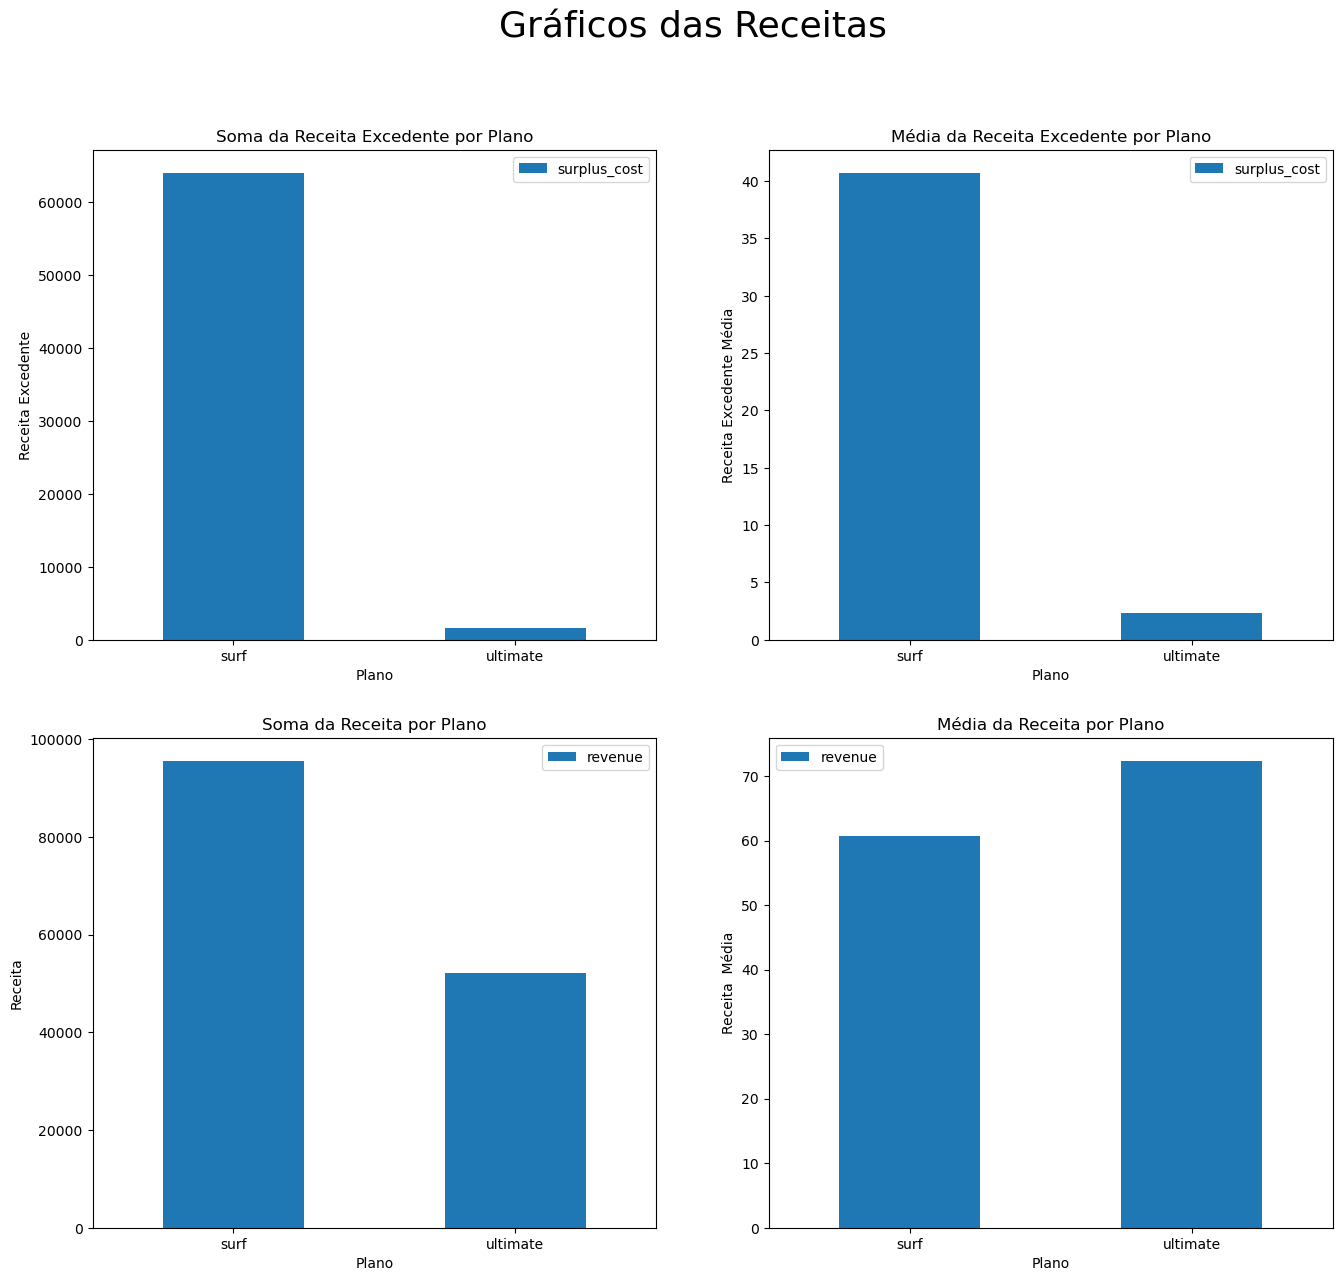

In [87]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,14))

plt.suptitle("Gráficos das Receitas", fontsize = 26)

df_final.pivot_table(index='plan', values='surplus_cost', aggfunc='sum').plot(kind = 'bar', ax=axs[0,0])
axs[0, 0].set_title('Soma da Receita Excedente por Plano')
axs[0, 0].set_xlabel('Plano')
axs[0, 0].set_ylabel('Receita Excedente')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=360)

df_final.pivot_table(index='plan', values='surplus_cost', aggfunc='mean').plot(kind = 'bar', ax=axs[0,1])
axs[0,1].set_title('Média da Receita Excedente por Plano')
axs[0, 1].set_xlabel('Plano')
axs[0, 1].set_ylabel('Receita Excedente Média')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=360)


df_final.pivot_table(index='plan', values='revenue', aggfunc='sum').plot(kind = 'bar', ax=axs[1,0])
axs[1,0].set_title('Soma da Receita por Plano')
axs[1, 0].set_xlabel('Plano')
axs[1, 0].set_ylabel('Receita')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=360)


df_final.pivot_table(index='plan', values='revenue', aggfunc='mean').plot(kind = 'bar',  ax=axs[1,1])
axs[1,1].set_title('Média da Receita por Plano')
axs[1,1].set_xlabel('Plano')
axs[1,1].set_ylabel('Receita  Média')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=360)


plt.show()

O plano surf possui uma receita vinda do gasto adicinal dos usuários bem maior do que o plano ultimate, com a receita total vida do gasto excedente vindo praticamento todo do plano surplus.

Em relação a receita vinda do valor mensal mais os gastos adicionais, a receita média foi maior para os planos ultimate. A receita média do plano ultimate ficou proxima de seu valor mensal de 70 doláres, enquanto a receita média do plano surf ficou em torno de 60 doláres. O total vido da receita foi maior para o plano surf, pois ele representa 68% dos usuários.

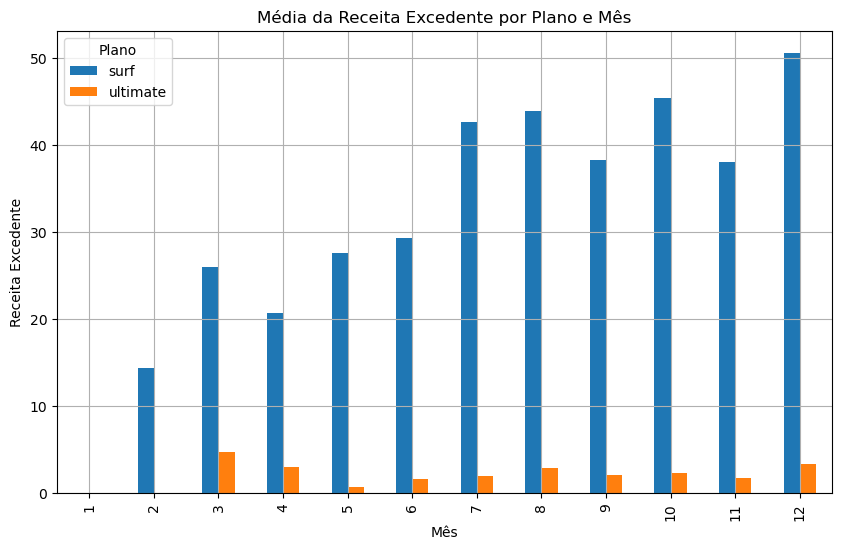

In [88]:
graf_month(df_final.pivot_table(index='month', columns='plan', values='surplus_cost', aggfunc='mean'),\
           'Receita Excedente', 'Média da Receita Excedente por Plano e Mês', 'Plano')

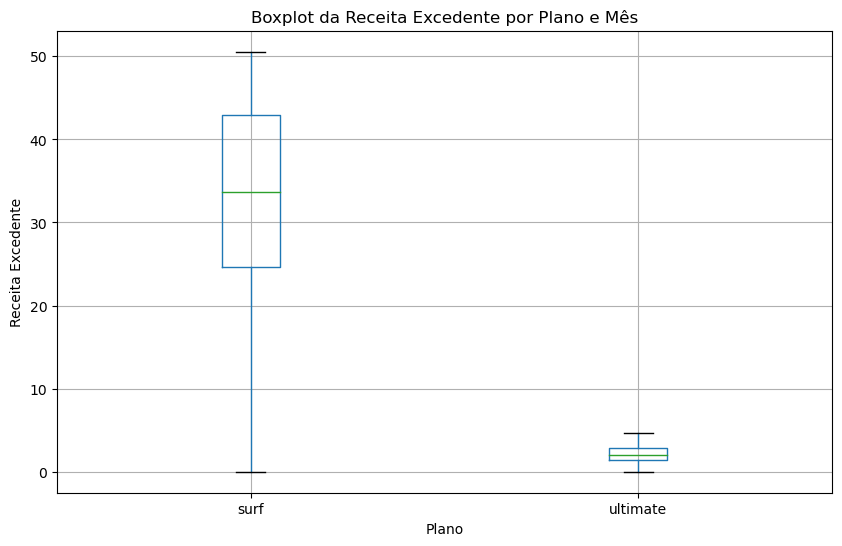

In [89]:
box_month(df_final.pivot_table(index='month', columns='plan', values='surplus_cost', aggfunc='mean'),\
          'Plano', 'Receita Excedente', 'Boxplot da Receita Excedente por Plano e Mês')

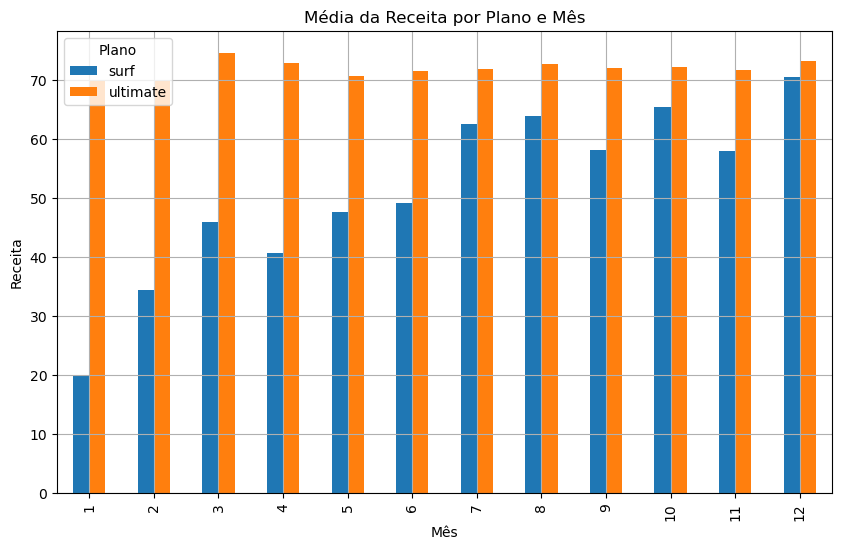

In [90]:
graf_month(df_final.pivot_table(index='month', columns='plan', values='revenue', aggfunc='mean'),\
           'Receita', 'Média da Receita por Plano e Mês', 'Plano')

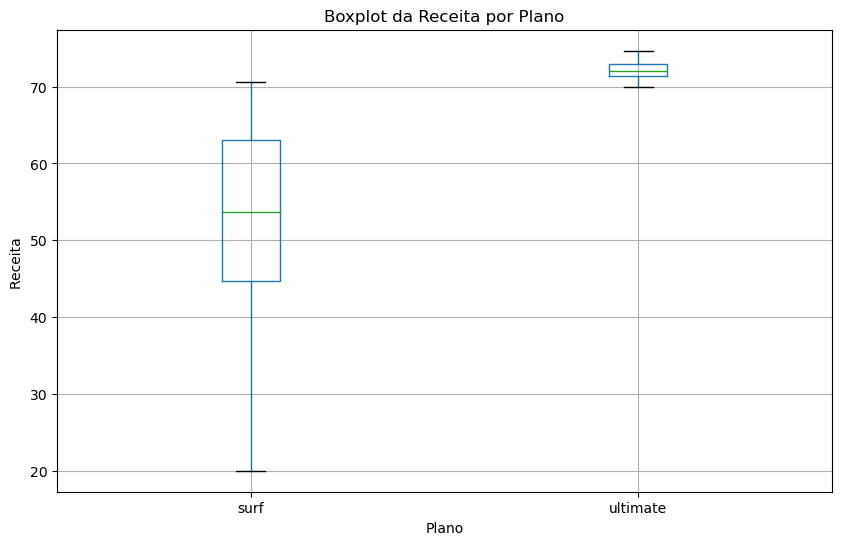

In [91]:
box_month(df_final.pivot_table(index='month', columns='plan', values='revenue', aggfunc='mean'),\
          'Plano', 'Receita ', 'Boxplot da Receita por Plano')

O plano surf possui uma grande variação de receita, entre 20 a 70 dólares. O plano ultimate possui baixa variação, entre 70 a 75 dólares.

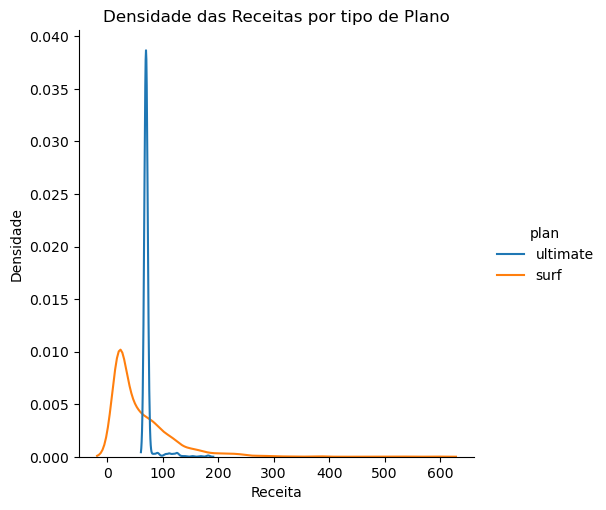

In [92]:
# Densidade das Receitas por tipo de Plano
densi_graph(df_final , 'revenue' , 'plan', 'Densidade das Receitas por tipo de Plano', 'Receita')


Verei a relação entre a receita e a região dos usuários.

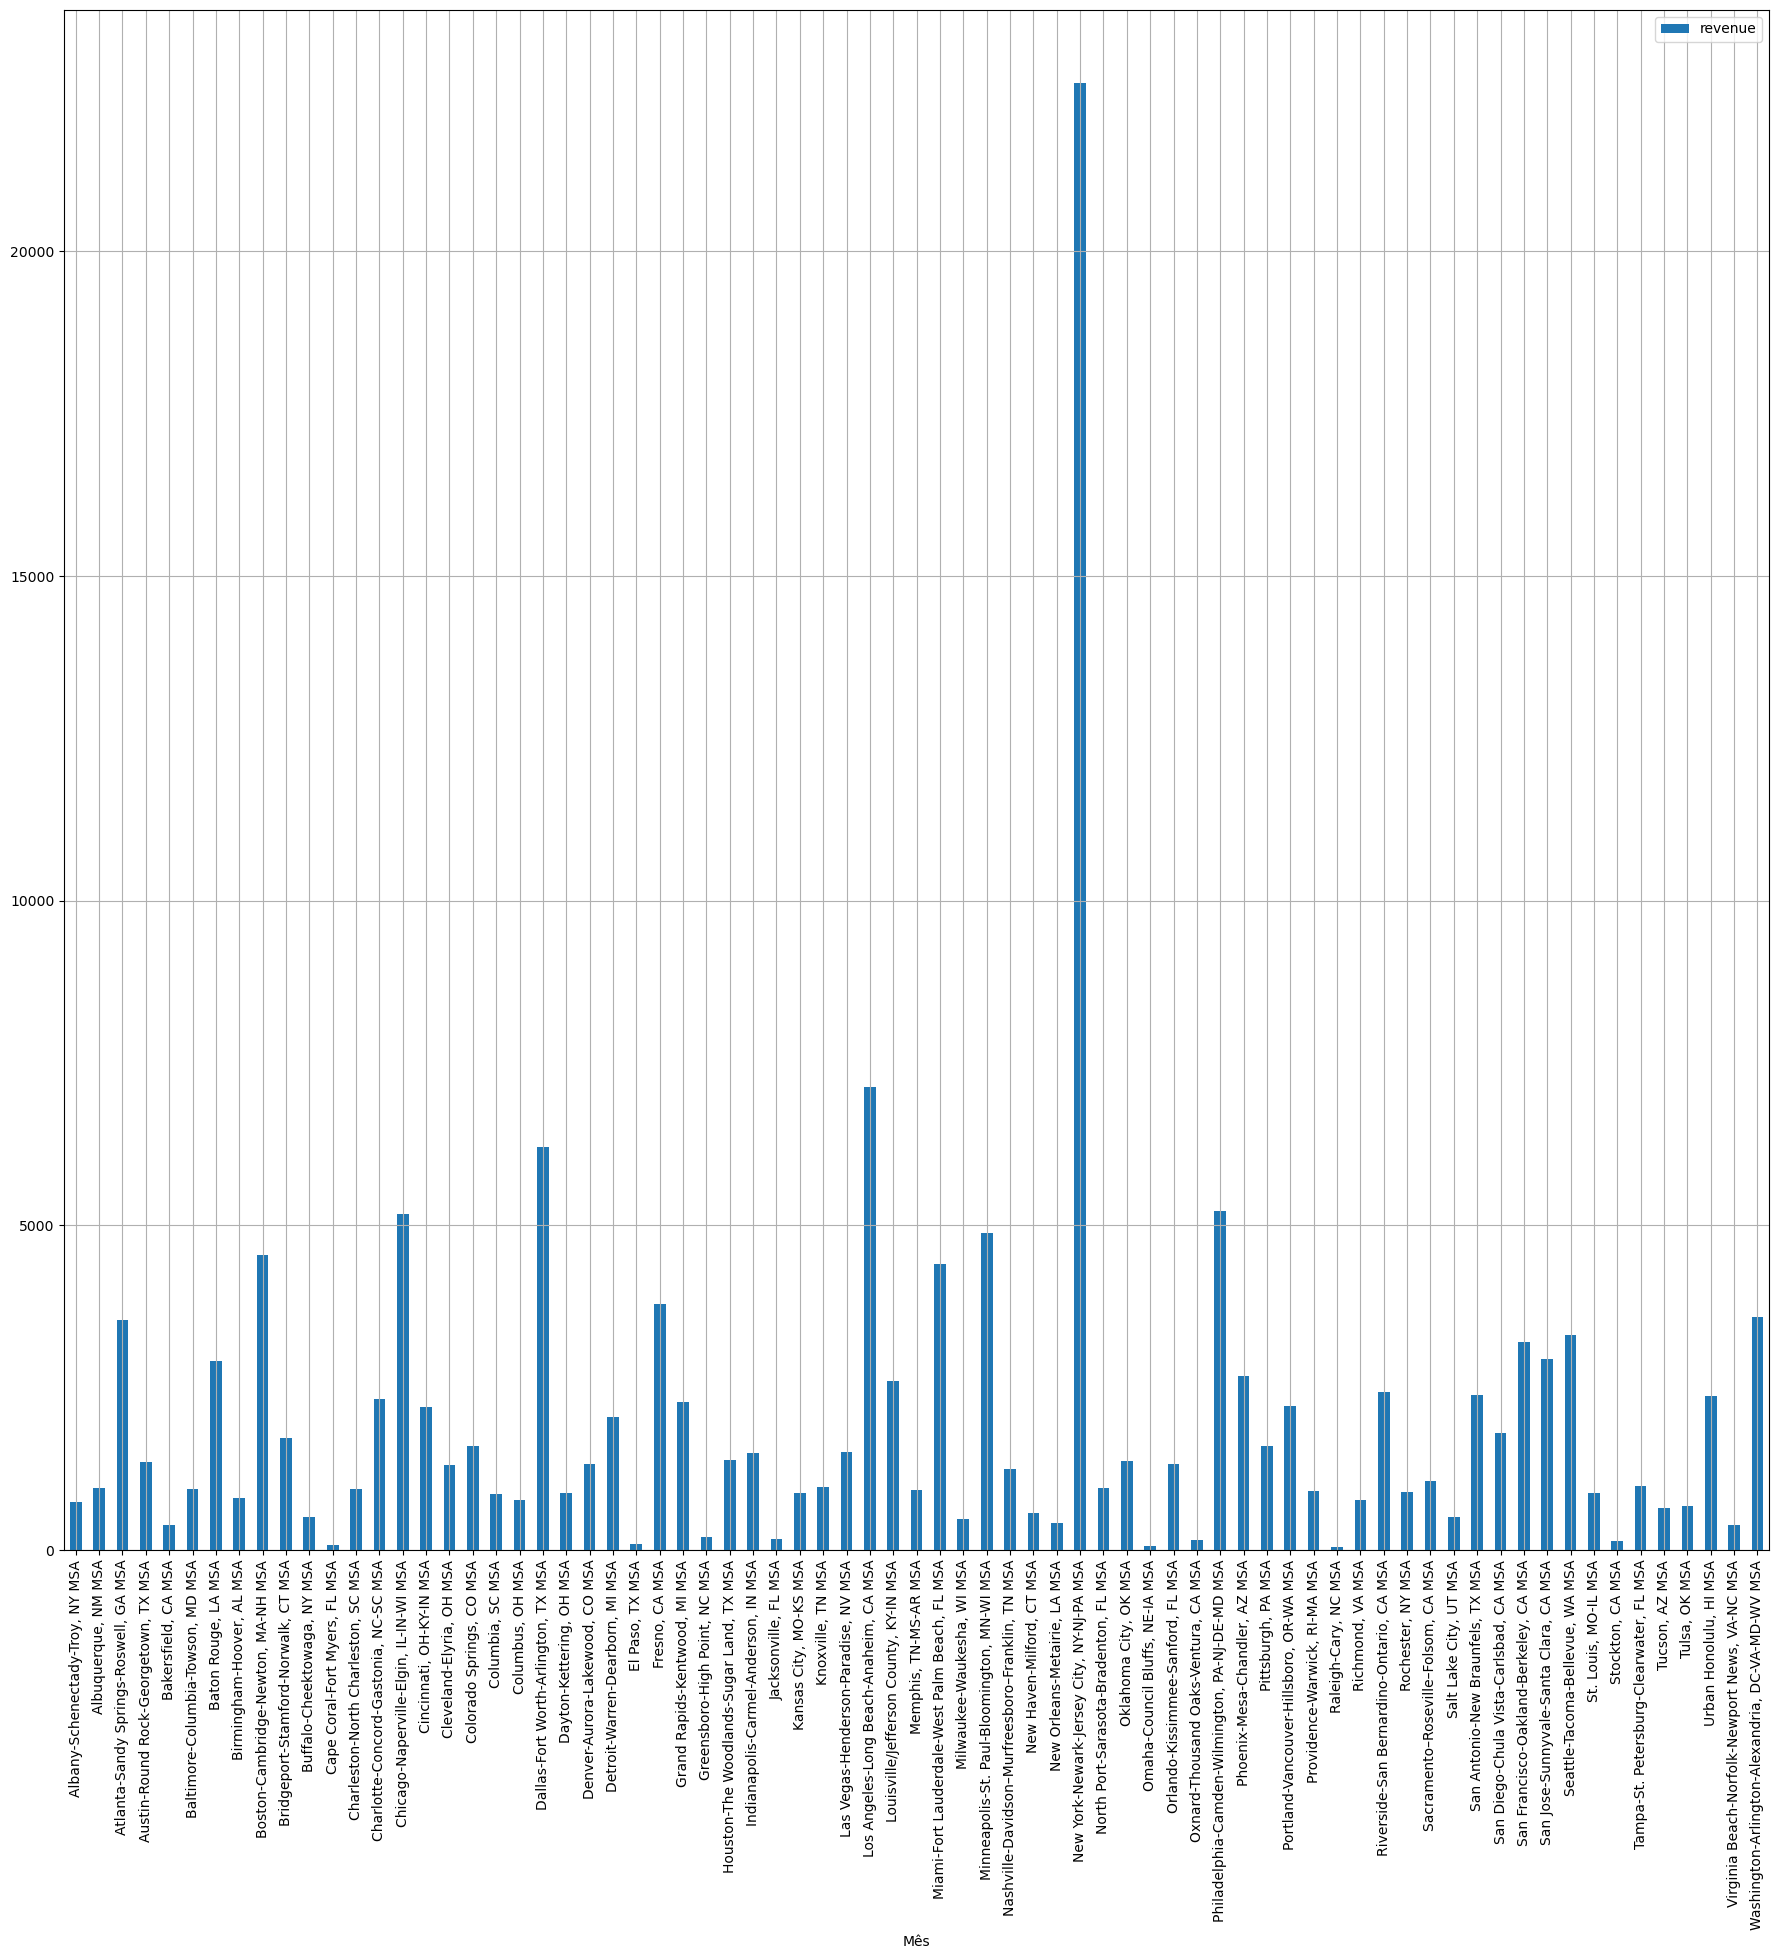

In [93]:

fig, ax = plt.subplots(figsize=(22,20))

df_final.pivot_table(index='city',  values='revenue', aggfunc='sum').plot(kind='bar', ax=ax,grid=True)

# Adiciona os rótulos do eixo x e legenda
ax.set_xlabel('Mês')

plt.show()

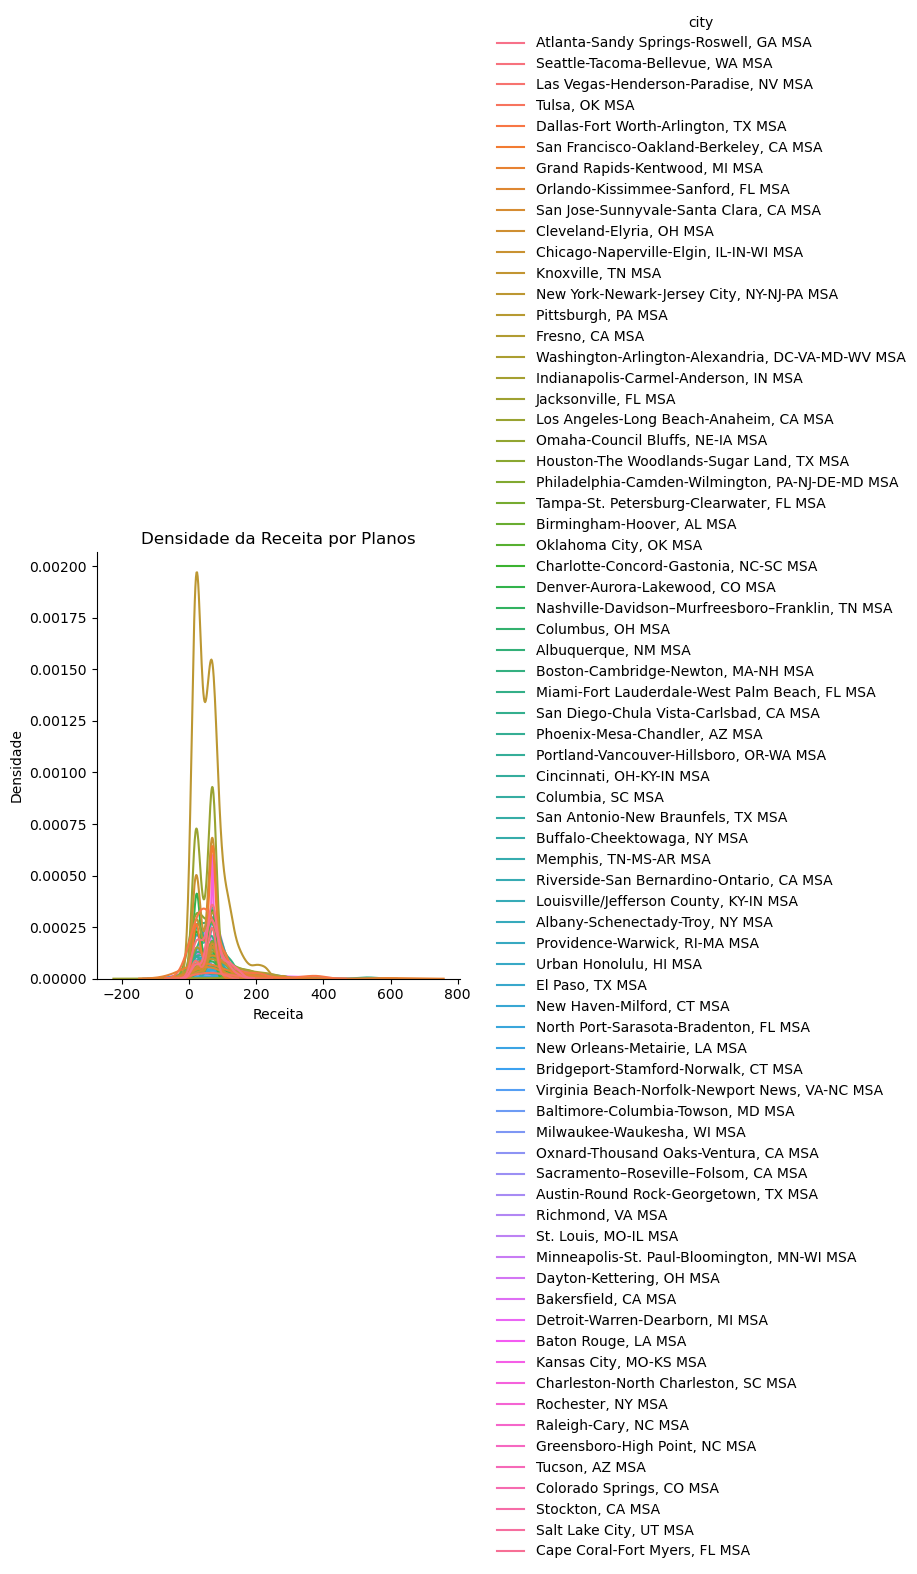

In [94]:
# Densidade das receitas por tipo de Plano
sns.displot(data=df_final, x='revenue', hue="city", kind="kde");
plt.title('Densidade da Receita por Planos');
plt.ylabel('Densidade')
plt.xlabel('Receita')
plt.show();

A região "New York-Newark-Jersey City, NY-NJ-PA MSA" possui a maior quantidade de receita. Em primeira análise ela seria interessante para marketing. Será feito um teste estatístico para confirmar que essa região possui realmente diferença em relação as outras regiões.

Em conclusão, o plano ultimate gerá uma receita média maior do que o plano surf. Os planos possuem curvas de densidade diferentes.  Sendo assim, o plano ultimate seria mais interessante para forcar em uma campanha publicitária. Mas deve ser feito um teste estatística para saber se existe uma diferença real ou foi causado apenas pelo acaso.

## Testar hipóteses estatísticas

Os testes de hipóteses são testes estatísticos que permitem saber rejeitar que dois grupos amostrais sejam iguais estatisticamente, dados um certo nível de significância. Com a hipótese zero sendo rejeitada se o p-value for menor que a significância.

Para os dois testes de hipótese, o nível de significância,  o alfa, será de 5%.

O primeiro teste, a receita média dos usuários dos planos Ultimate e Surf são diferentes.

- Hipótese nula: a receita média dos usuários dos planos Ultimate e Surf são iguais.
- Hipótese alternativa: a receita média dos usuários dos planos Ultimate e Surf são diferentes.


In [95]:
p_surf = df_final.query('plan == "surf"')['revenue']

p_ultimate = df_final.query('plan == "ultimate"')['revenue']

alpha = 0.05

In [96]:
print(f'Média de surf: {p_surf.mean()}')
print(f'Variância de surf: {p_surf.var()}\n')

print(f'Média de ultimate: {p_ultimate.mean()}')
print(f'Variância de ultimate: {p_ultimate.var()}')


Média de surf: 60.70640813731716
Variância de surf: 3067.835152293874

Média de ultimate: 72.31388888888888
Variância de ultimate: 129.8484855509191


In [97]:
# Teste as hipóteses
revenue_test = ttest_ind(p_surf, p_ultimate)

print(f'p-value: {revenue_test.pvalue}')

if revenue_test.pvalue < alpha:
    print('Hipótese zero rejeitada')
else:
    print('Hipótese zero não pode ser rejeitada')
        

p-value: 2.862674510698644e-08
Hipótese zero rejeitada


O segundo teste, a receita média dos usuários da área de NY-NJ é diferente dos usuários de outras regiões.

- Hipótese nula: a receita média dos usuários da área de NY-NJ é igual dos usuários de outras regiões.
- Hipótese alternativa: a receita média dos usuários da área de NY-NJ é diferente dos usuários de outras regiões.

In [98]:
ny = df_final.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue']

not_ny = df_final.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')['revenue']

alpha = 0.05

In [99]:
print(f'Média de NY-NJ-PA MSA: {ny.mean()}')
print(f'Variância de NY-NJ-PA MSA: {ny.var()}\n')

print(f'Média das outras regiões: {not_ny.mean()}')
print(f'Variância das outras regiões: {not_ny.var()}')


Média de NY-NJ-PA MSA: 59.92135278514591
Variância de NY-NJ-PA MSA: 1895.545689920425

Média das outras regiões: 65.22277139874734
Variância das outras regiões: 2225.0479943519053


In [100]:
# Teste as hipóteses
city_test = ttest_ind(ny, not_ny)

print(f'p-value: {city_test.pvalue}')

if city_test.pvalue < alpha:
    print('Hipótese zero rejeitada')
else:
    print('Hipótese zero não pode ser rejeitada')


p-value: 0.043557431621342436
Hipótese zero rejeitada


## Conclusão geral

Primeiramente, foi feito a correção dos tipos de dados e o enriquecimento dos dados. Todas as tabelas que possuiam data tiveram o seu tipo mudado de *objcet* para *datetime*. As chamadas e usos de dados com zero foram retiradas das tabelas. Os minutos da tabela `df_calls` foi arredondado para cima, e na tabela `df_net` foi criado a coluna `gb_used` para armazenar a quantidade de gigabyes utilizados.

Em seguida, os dados das tabelas relevantes para a análise foram agregados no dataframe `df_final`. FOi agregado por usuário e por mês o número de chamadas, os minutos utilizados, a quantidade de mensagens, os dados utilizados, o plano, a região e a receita proveniente daquele mês.

Dessa forma, foi visto através de gráficos o comportamento dos usuários por plano. Foi visto a duração média das chamadas, a quantidade média de mensagens por mês e o uso de dados médio por mês, entre outras visualizações. Foi percebido através da análise que o comportamento dos usuários do plano surf não difere do comportamento do plano ultimate. 

Sendo assim, foi análisado o valor médio da receita por plano. Foi encontrado que a parte da receita proveniente do uso adicional de minutos, mensagens ou dados vem majoritariamento dos usuários do plano surf. A receita total média é maior para os usuários do plano ultimate que está em 72 dólares, para o plano surf é de 60 dólares. Também foi identificado que a maior parte da receita é proveniente da região "NY-NJ-PA MSA". Foram feitos testes estatísticos para identificar se a receita média e  a soma da receita por região eram populações estatísticas diferentes, em ambos o resultado demonstrou que as diferenças são reais.

Concluo que o melhor plano para ser feito campanha publicitária é o plano ultimate por trazer uma receita média maior. E focar na região "NY-NJ-PA MSA" que provem maior receita.